In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electron-microscopy-dataset/test/label/label140.tif
/kaggle/input/electron-microscopy-dataset/test/label/label20.tif
/kaggle/input/electron-microscopy-dataset/test/label/label32.tif
/kaggle/input/electron-microscopy-dataset/test/label/label121.tif
/kaggle/input/electron-microscopy-dataset/test/label/label61.tif
/kaggle/input/electron-microscopy-dataset/test/label/label47.tif
/kaggle/input/electron-microscopy-dataset/test/label/label23.tif
/kaggle/input/electron-microscopy-dataset/test/label/label67.tif
/kaggle/input/electron-microscopy-dataset/test/label/label9.tif
/kaggle/input/electron-microscopy-dataset/test/label/label103.tif
/kaggle/input/electron-microscopy-dataset/test/label/label132.tif
/kaggle/input/electron-microscopy-dataset/test/label/label122.tif
/kaggle/input/electron-microscopy-dataset/test/label/label100.tif
/kaggle/input/electron-microscopy-dataset/test/label/label70.tif
/kaggle/input/electron-microscopy-dataset/test/label/label94.tif
/kaggle/input/electr

In [2]:
def load_image_mask_patches(image_dir, label_dir, patch_size=256):
    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".tif")])
    label_paths = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".tif")])

    image_patches = []
    label_patches = []

    for img_path, lbl_path in zip(image_paths, label_paths):
        img = tiff.imread(img_path).astype(np.float32) / 255.0
        lbl = tiff.imread(lbl_path).astype(np.float32) / 255.0

        if img.ndim == 3:
            img = img[:, :, 0]
        if lbl.ndim == 3:
            lbl = lbl[:, :, 0]

        img_patches = patchify(img, (patch_size, patch_size), step=patch_size)
        lbl_patches = patchify(lbl, (patch_size, patch_size), step=patch_size)

        for i in range(img_patches.shape[0]):
            for j in range(img_patches.shape[1]):
                image_patch = img_patches[i, j]
                label_patch = lbl_patches[i, j]

                image_patch = np.expand_dims(image_patch, axis=-1)  # (256, 256, 1)
                label_patch = np.expand_dims(label_patch, axis=-1)

                image_patches.append(image_patch)
                label_patches.append(label_patch)

    return np.array(image_patches), np.array(label_patches)


In [5]:
!pip install patchify
import numpy as np
import tifffile as tiff
from patchify import patchify
import os
from tqdm import tqdm
train_images, train_labels = load_image_mask_patches(
    image_dir='/kaggle/input/electron-microscopy-dataset/train/data',
    label_dir='/kaggle/input/electron-microscopy-dataset/train/label',
    patch_size=256
)

test_images, test_labels = load_image_mask_patches(
    image_dir='/kaggle/input/electron-microscopy-dataset/test/data',
    label_dir='/kaggle/input/electron-microscopy-dataset/test/label',
    patch_size=256
)

print("Train:", train_images.shape, train_labels.shape)
print("Test:", test_images.shape, test_labels.shape)


Train: (1980, 256, 256, 1) (1980, 256, 256, 1)
Test: (1980, 256, 256, 1) (1980, 256, 256, 1)


In [6]:
def create_tf_dataset(images, labels, batch_size=16, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [7]:
import tensorflow as tf
train_dataset = create_tf_dataset(train_images, train_labels, batch_size=8, shuffle=True)
test_dataset = create_tf_dataset(test_images, test_labels, batch_size=8, shuffle=False)


2025-06-23 09:54:36.793378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750672476.993037      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750672477.055970      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1750672490.458493      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750672490.459164      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

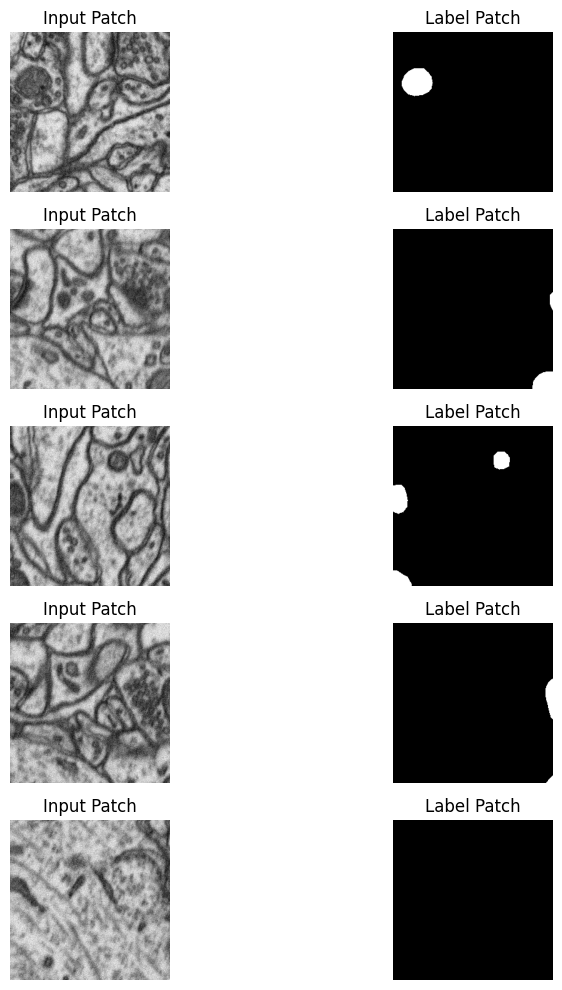

In [8]:
# Get one batch of image-label pairs from the dataset
for images, labels in train_dataset.take(1):
    break  # only one batch

images_np = images.numpy()
labels_np = labels.numpy()

import matplotlib.pyplot as plt

def show_image_label_pairs(images, labels, num=5):
    plt.figure(figsize=(10, num * 2))
    
    for i in range(num):
        plt.subplot(num, 2, 2*i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title("Input Patch")
        plt.axis("off")

        plt.subplot(num, 2, 2*i + 2)
        plt.imshow(labels[i].squeeze(), cmap='gray')
        plt.title("Label Patch")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

show_image_label_pairs(images_np, labels_np, num=5)


In [9]:
input_shape = (256, 256, 1)


In [10]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x
#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x
    
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [11]:
model = build_unet(input_shape)

In [12]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [14]:
seed = 24
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np

# Image augmentation
img_data_gen_args = dict(
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.5,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Mask augmentation (same params + binarization)
mask_data_gen_args = dict(
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.5,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
    preprocessing_function=lambda x: np.where(x > 0, 1, 0).astype(x.dtype)
)

# Create the ImageDataGenerators
image_data_generator = ImageDataGenerator(**img_data_gen_args)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)


In [15]:
batch_size = 8

image_generator = image_data_generator.flow(
    train_images,
    batch_size=batch_size,
    seed=seed
)

mask_generator = mask_data_generator.flow(
    train_labels,
    batch_size=batch_size,
    seed=seed
)

# Combine them into one generator
train_generator = zip(image_generator, mask_generator)


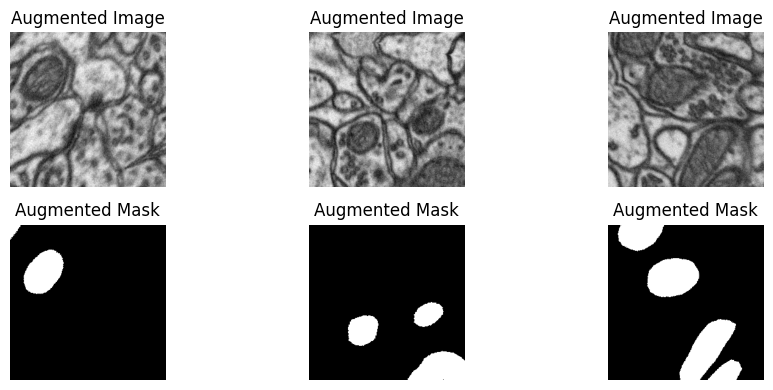

In [17]:
import matplotlib.pyplot as plt

img_batch, mask_batch = next(train_generator)

plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img_batch[i].squeeze(), cmap='gray')
    plt.title('Augmented Image')
    plt.axis('off')

    plt.subplot(2, 3, i + 4)
    plt.imshow(mask_batch[i].squeeze(), cmap='gray')
    plt.title('Augmented Mask')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [19]:
def combined_generator(image_gen, mask_gen):
    while True:
        yield next(image_gen), next(mask_gen)



In [20]:
train_generator = combined_generator(image_generator, mask_generator)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    validation_data=(test_images, test_labels),
    epochs=25
)


Epoch 1/25


I0000 00:00:1750672633.471135      86 service.cc:148] XLA service 0x7ad774002b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750672633.471962      86 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750672633.471985      86 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750672635.179861      86 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-23 09:57:20.035947: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[8,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_s

245/247 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.9366 - loss: 0.1805

E0000 00:00:1750672820.977196      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750672821.201721      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750672826.061723      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750672826.366924      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750672832.434075      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.9368 - loss: 0.1800

E0000 00:00:1750672952.836959      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750672953.095111      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


247/247 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.9369 - loss: 0.1798 - val_accuracy: 0.0930 - val_loss: 6.9821
Epoch 2/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 161s 651ms/step - accuracy: 0.9717 - loss: 0.0726 - val_accuracy: 0.9518 - val_loss: 0.1692
Epoch 3/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 161s 654ms/step - accuracy: 0.9789 - loss: 0.0548 - val_accuracy: 0.9817 - val_loss: 0.0542
Epoch 4/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 160s 651ms/step - accuracy: 0.9830 - loss: 0.0443 - val_accuracy: 0.9680 - val_loss: 0.2074
Epoch 5/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 161s 653ms/step - accuracy: 0.9837 - loss: 0.0422 - val_accuracy: 0.9769 - val_loss: 0.0931
Epoch 6/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 161s 653ms/step - accuracy: 0.9858 - loss: 0.0366 - val_accuracy: 0.9829 - val_loss: 0.0603
Epoch 7/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 161s 653ms/step - accuracy: 0.9863 - loss: 0.0359 - val_accuracy: 0.9886 - val_loss: 0.0305
Epoch 8/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 161s 653ms/step - accuracy: 0.9870 - loss: 0.0344 

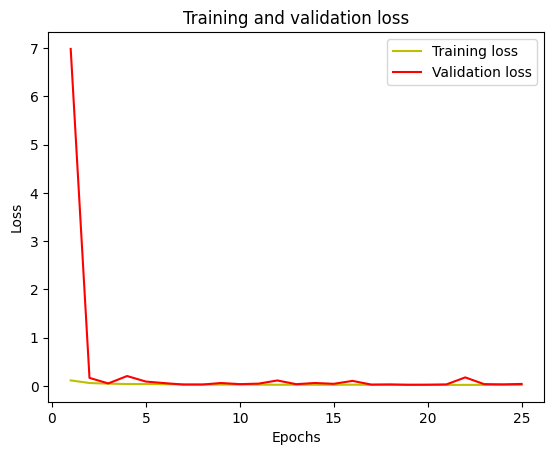

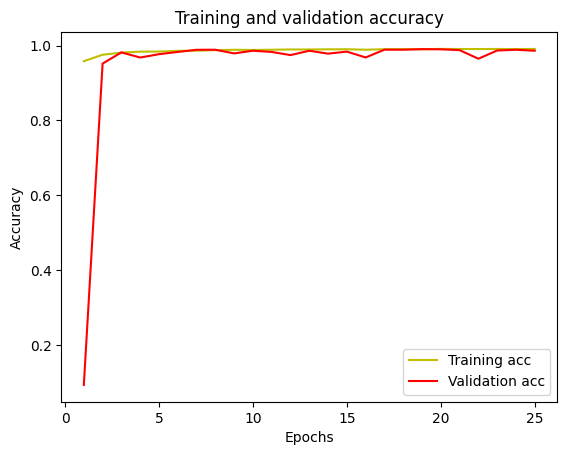

In [21]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Step 1: Predict masks for test set
y_pred = model.predict(test_images, verbose=1)
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)

# Step 2: Compute IoU (Intersection over Union)
intersection = np.logical_and(test_labels, y_pred_thresholded)
union = np.logical_or(test_labels, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)

print("IoU score is:", round(iou_score, 4))


62/62 ━━━━━━━━━━━━━━━━━━━━ 47s 730ms/step
IoU score is: 0.7487


In [25]:
# Predict on all test images
y_pred = model.predict(test_images)
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)

# Compute pixel accuracy
correct = np.sum(y_pred_thresholded == test_labels)
total = np.prod(test_labels.shape)

pixel_accuracy = correct / total
print("Pixel-wise Accuracy:", round(pixel_accuracy * 100, 2), "%")


62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 698ms/step
Pixel-wise Accuracy: 98.61 %


In [29]:
def dice_score(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

dice = dice_score(test_labels, y_pred_thresholded)
print("Dice Coefficient:", round(dice, 4))


Dice Coefficient: 0.8563


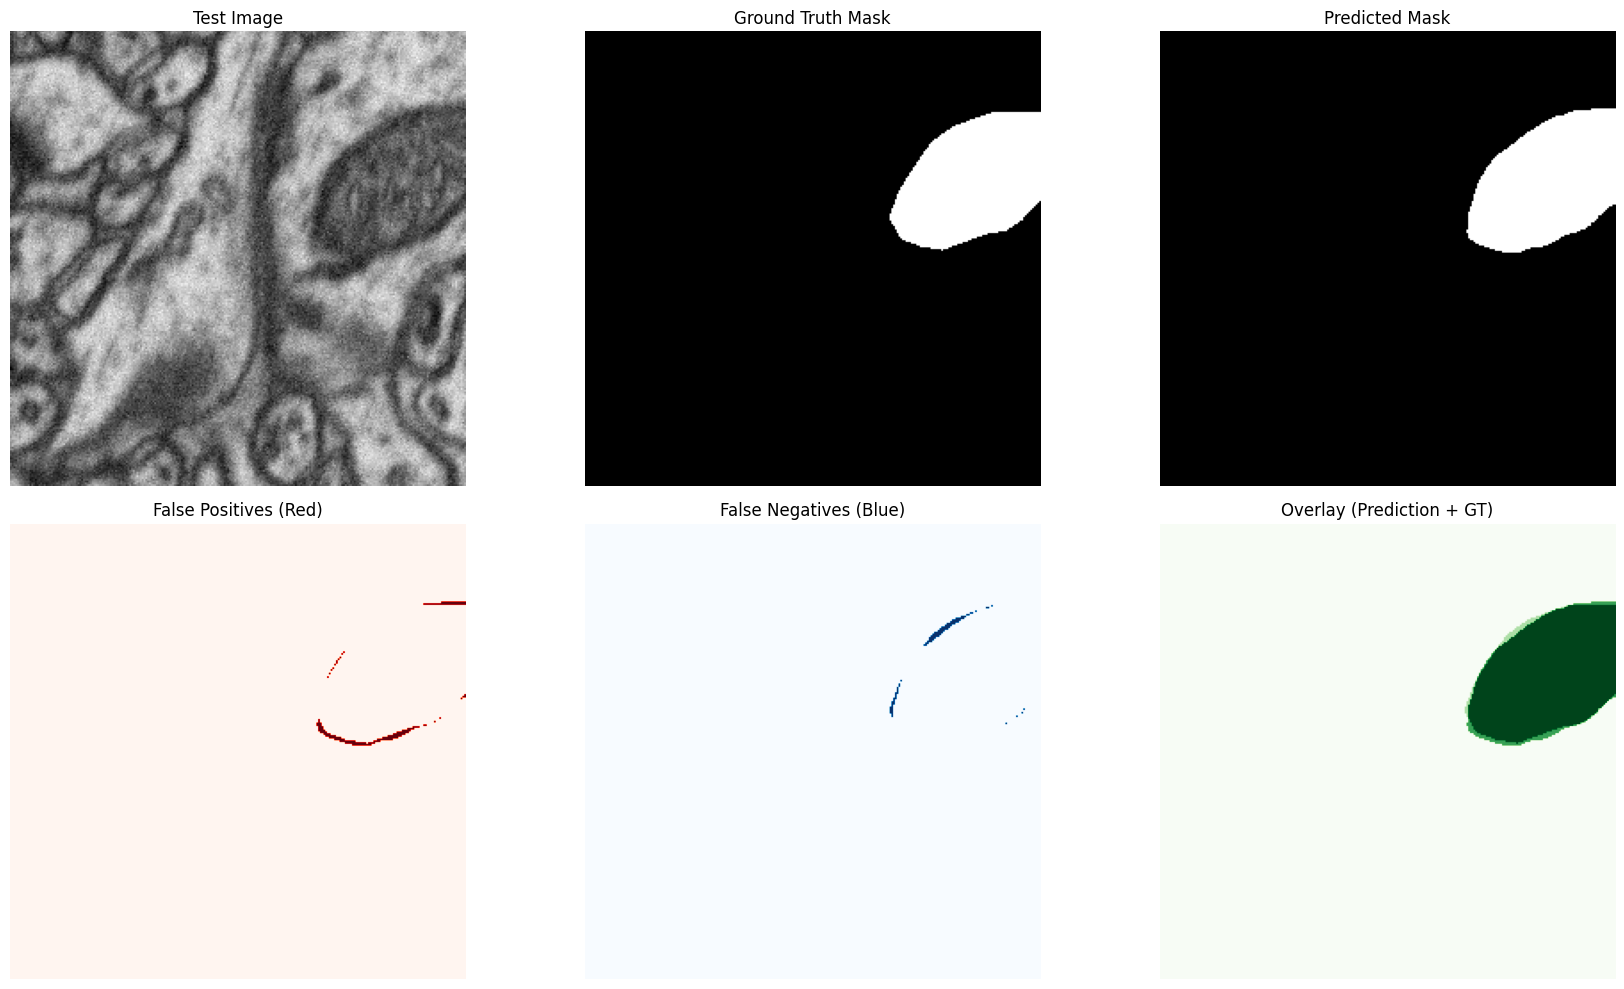

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Pick a random test sample
i = random.randint(0, len(test_images) - 1)

test_img = test_images[i].squeeze()
ground_truth = test_labels[i].squeeze()
prediction = y_pred_thresholded[i].squeeze()

# Compute false positives and false negatives
false_positive = np.logical_and(prediction == 1, ground_truth == 0)
false_negative = np.logical_and(prediction == 0, ground_truth == 1)

# Plot all
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.title('Test Image')
plt.imshow(test_img, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(ground_truth, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title('Predicted Mask')
plt.imshow(prediction, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title('False Positives (Red)')
plt.imshow(false_positive, cmap='Reds')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('False Negatives (Blue)')
plt.imshow(false_negative, cmap='Blues')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title('Overlay (Prediction + GT)')
overlay = np.zeros_like(test_img)
overlay[ground_truth == 1] = 0.3  # Ground truth in green
overlay[prediction == 1] += 0.6  # Prediction in brighter
plt.imshow(overlay, cmap='Greens')
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


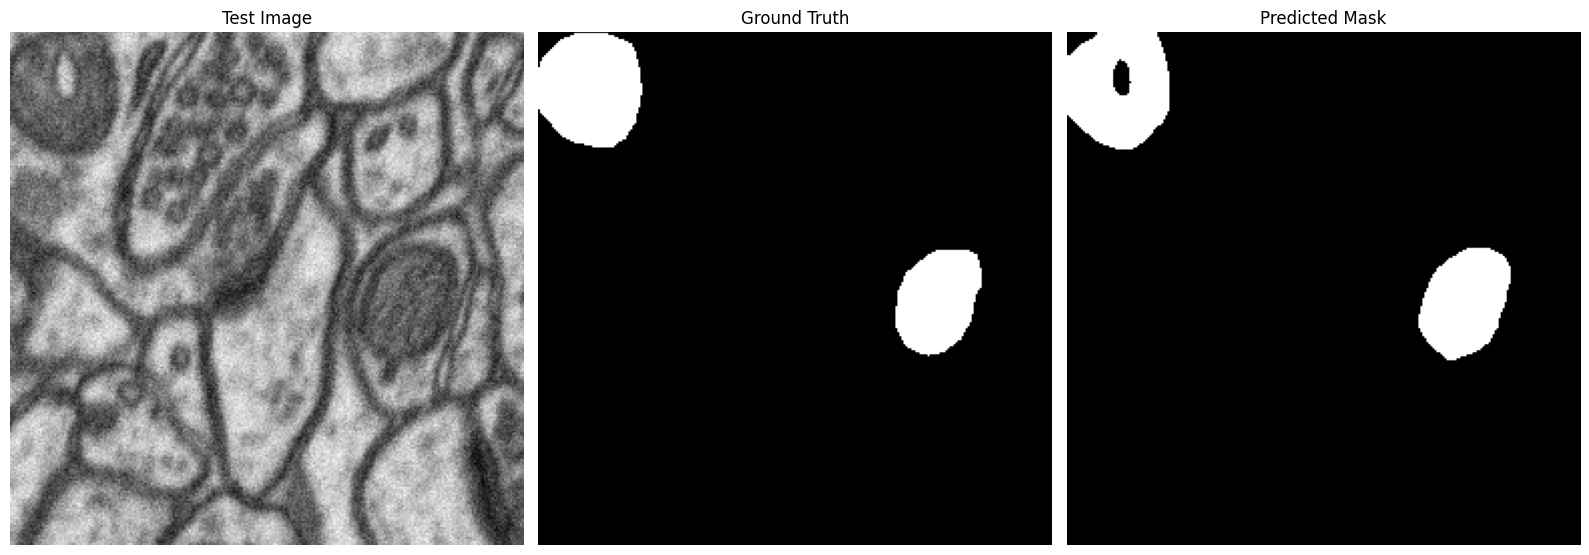

In [24]:
# Randomly select a test image
test_img_number = random.randint(0, len(test_images) - 1)

# Get image and ground truth
test_img = test_images[test_img_number]
ground_truth = test_labels[test_img_number]

# Preprocess input (shape = (1, 256, 256, 1))
test_img_input = np.expand_dims(test_img, axis=0)

# Predict
prediction = model.predict(test_img_input)[0, :, :, 0]
prediction_thresholded = (prediction > 0.5).astype(np.uint8)

# Plot the image, ground truth, and prediction
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(test_img.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ground Truth')
plt.imshow(ground_truth.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Predicted Mask')
plt.imshow(prediction_thresholded, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
